In [259]:
import scipy.io
import numpy as np
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
import os
import time

from SWE_utils_numpy_standalone import *
from scipy.signal import firwin, butter, buttord, freqz

from arrus.ops.us4r import *
from arrus.ops.imaging import *
from arrus.metadata import *
from arrus.devices.probe import *
from arrus.devices.us4r import Us4RDTO
from arrus.utils.imaging import *

# Script parameters
Configure the reconstruction parameters of individual steps of the algorithm

In [260]:
# General settings
dataset_id = 340
directory  = '../Datasets'

# Constants
c              = 1540.0
probe_elements = 128
probe_pitch    = 0.298e-3
fs             = 65e6

# Sequence parameters
pwi_txFreq   = 4.4e6
pwi_nCycles  = 2
pwi_txAngles = [-4.0, 0.0, 4.0]
pwi_txPri    = 100e-6
pwi_fri      = 2* pwi_txPri

# RF Filter
rf_filter_band        = [4e6, 7e6]    # Desired pass band, Hz
rf_filter_trans_width = 1e6           # Width of transition from pass band to stop band, Hz
rf_filter_numtaps     = 236           # Size of the FIR filter.

# Post down conversion IQ filtering
demod_filter_cutoff = 0.5 * 4.4e6       # Desired cutoff frequency, Hz
demod_filter_trans_width = 0.5 * 4.4e6  # Width of transition from pass band to stop band, Hz
demod_filter_numtaps = 128              # Size of the FIR filter.

# Beamforming
px_size = 0.2  # in [mm]
x_grid = np.arange(-20, 20, px_size) * 1e-3
z_grid = np.arange(0, 50, px_size)   * 1e-3

# Shear wave detection
swd_mode              = 'kasai'
swd_zGate_length      = 4 
swd_ensemble_length   = 4

# Input parameters
df_sws_range = [0.5, 4.0];
df_f_range   = [40.0, 800.0];
df_k_range   = 0.9;

# SWS estimation
swse_interp_factor = 5;
swse_interp_order  = 2
swse_d             = 14;
swse_frames        = [0, 115];
swse_SWV_range     = [0.5, 4.0];
swse_x_range       = [[0, 420], [0, 420]]
swse_z_clip        = [5, 10]

# Post-processing
median_filter_size = 5


## Load the dataset

In [261]:
# Load a dataset
sid = 'id' + str(dataset_id)
# Search for the file
for root, dirs, files in os.walk(directory):
    for file in files:
        if sid in file:
            file_path = os.path.join(root, file)
            data = sp.io.loadmat(file_path)

data["rf_data"].shape
rf = data["rf_data"]
rf = rf[np.newaxis, ...]
Nframes = rf.shape[1]
rf.shape

(1, 150, 4224, 128)

In [262]:
# Crop the data (# of frames)
rf = rf[:, 0:125, ...]
rf.shape

(1, 125, 4224, 128)

# Beamforming

### Design filters

In [263]:
## Function to plot the filter response
def plot_FIR_response(fs, taps, w, h):
    "Utility function to plot response functions"
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 9))
    ax0.plot(range(len(taps)), taps)
    ax0.set_xlabel("Tap")
    ax0.set_ylabel("Value")
    
    ax1.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax1.set_ylim(-80, 5)
    ax1.set_xlim(0, 0.5*fs)
    ax1.grid(True)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Gain (dB)')
    
    ax2.plot(0.5*fs*w/np.pi, np.angle(h))
    ax2.set_xlim(0, 0.5*fs)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Phase (rad)")

## Design a band-pass FIR filter for RF filtering of raw channel data
band = rf_filter_band                # Desired pass band, Hz
trans_width = rf_filter_trans_width  # Width of transition from pass band to stop band, Hz
numtaps = rf_filter_numtaps          # Size of the FIR filter.

edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*fs]
rf_fir_taps = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)
if(0):
    w, h = signal.freqz(rf_fir_taps, [1], worN=2000)
    plot_FIR_response(fs, rf_fir_taps, w, h)

## Design a low-pass FIR filter for filtering of down-conversion products
# Specify the filter parameters    
cutoff = demod_filter_cutoff            # Desired cutoff frequency, Hz
trans_width = demod_filter_trans_width  # Width of transition from pass band to stop band, Hz
numtaps = demod_filter_numtaps          # Size of the FIR filter.
iq_fir_taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)
if(0):
    w, h = signal.freqz(iq_fir_taps, [1], worN=2000)
    plot_FIR_response(fs, iq_fir_taps, w, h)           

## Metadata

In [264]:
tx_angles = np.tile(pwi_txAngles, int(np.ceil(rf.shape[1]/len(pwi_txAngles))))*np.pi/180

sequence = PwiSequence(
    pulse=Pulse(center_frequency=pwi_txFreq, n_periods=pwi_nCycles, inverse=False),
    rx_sample_range=(0, rf.shape[1]),
    speed_of_sound=c, # [m/s],
    angles=tx_angles,
    pri=pwi_txPri
)

model=ProbeModel(
    model_id=ProbeModelId("atl", "l7-4"),
    n_elements=probe_elements,
    pitch=probe_pitch,
    curvature_radius=0,
)

probe = ProbeDTO(
    model=model
)

device=Us4RDTO(
    sampling_frequency=fs,
    probe=probe
)

context = arrus.metadata.FrameAcquisitionContext(
    device=device, 
    sequence=sequence,
    raw_sequence=None,
    medium=None,
    custom_data={})

data_desc=EchoDataDescription(
    sampling_frequency=fs,
)

metadata = ConstMetadata(context=context, data_desc=data_desc, input_shape=rf.shape, is_iq_data=False, dtype=np.int16, version=None)

In [265]:
# Run the pipeline (benchmark)
n = 1
start = time.time()
for i in range(n):
    dataout = sp.ndimage.convolve1d(rf, rf_fir_taps, axis=2)
end = time.time()
print(f"Average time: {(end-start)/n} [s]")

#dataout = sp.ndimage.convolve1d(rf, rf_fir_taps, axis=2)

Average time: 14.939810037612915 [s]


In [266]:
# Prepare for down-conversion
fs = 65e6
fc = 4.4e6
n_samples = 4224
t = (np.arange(0, n_samples) / fs).reshape(1, 1, -1)
mod_factor = (2 * np.cos(-2 * np.pi * fc * t) + 2 * np.sin(-2 * np.pi * fc * t) * 1j)
mod_factor = mod_factor.astype(np.complex64)
rft = np.transpose(rf, [0, 1, 3, 2])


In [267]:
# Down conversion
start = time.time()
d = mod_factor * rft
dataout = sp.ndimage.convolve1d(d, iq_fir_taps, axis=3)
end = time.time()
print(f"Average time: {(end-start)} [s]")



Average time: 15.873360872268677 [s]


## Pipeline: RF Filtering, Down-conversion and Beamforming

In [268]:
# Define the processing pipeline
processing = Pipeline(
    steps=(
        Transpose(axes=(0, 1, 3, 2)),
        #BandpassFilter(),
        FirFilter(taps=rf_fir_taps, num_pkg=None, filter_pkg=None),
        QuadratureDemodulation(),
        Decimation(filter_type="fir", filter_coeffs=iq_fir_taps, decimation_factor=1),
        ReconstructLri(x_grid=x_grid, z_grid=z_grid),
        Squeeze(),
    ),
    placement="/GPU:0"
)

# Prepare pipeline
processing.prepare(metadata)


deque([<arrus.metadata.ConstMetadata at 0x7f3d46f314f0>])

In [269]:
#Transfer data to GPU
din = cp.asarray(rf)

In [270]:
#Transfer data to GPU (benchmark)
n = 1
start = time.time()
for i in range(n):
    din = cp.asarray(rf)
cp.cuda.Stream.null.synchronize()
end = time.time()
print(f"Average time: {1000*(end-start)/n} [ms]")

Average time: 416.51248931884766 [ms]


In [271]:
# Run the pipeline
output = processing.process(din)

In [272]:
lri_data_gpu = output[0]
print(lri_data_gpu.shape)

(125, 200, 250)


In [273]:
lri_data = lri_data_gpu.get()

### Angle compounding

In [274]:
# Compounding prepare
AngleCompounder = AngleCompounding(nAngles=len(pwi_txAngles))
AngleCompounder.prepare()


In [275]:
# Compounding (benchmark)
n = 100
start = time.time()
for i in range(n):
    hri_data_gpu = AngleCompounder.process(data=lri_data)
end = time.time()
print(f"Average time: {1000*(end-start)/n} [ms]")

Average time: 49.48762893676758 [ms]


## Shear wave detection

In [276]:
# Shear wave detection
ShearDetector = ShearwaveDetection(mode=swd_mode, packet_size=swd_ensemble_length, z_gate=swd_zGate_length, frame_pri=pwi_fri, c=c, fc=pwi_txFreq, fs=fs)
ShearDetector.prepare(c=c, frame_pri=200e-6, fs=65e6)

In [277]:
print(hri_data_gpu.shape)

(121, 200, 250)


In [278]:
# Shear Wave Detection (benchmark)
n = 50
start = time.time()
for i in range(n):
    ddata = ShearDetector.process(data=hri_data_gpu)
end = time.time()
print(f"Average time: {1000*(end-start)/n} [ms]")

Average time: 220.03692626953125 [ms]


In [279]:
print(ddata.shape)

(249, 200, 120)


(249, 200, 120)


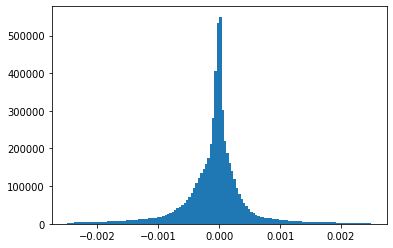

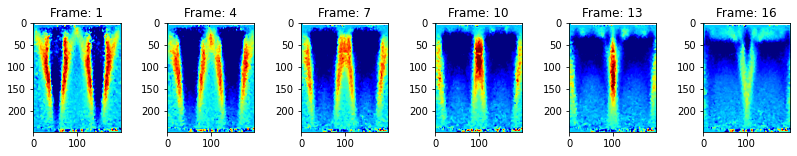

In [280]:
# Visualize data
ddata_cpu = ddata
getHistogram(data=ddata_cpu, Vrange = [-2.5e-3, 2.5e-3])
print(ddata_cpu.shape)
DrawShearWaveFrames(data=ddata_cpu, Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])

## Shear wave motion data filtering

In [281]:
print(ddata.shape)

(249, 200, 120)


In [282]:
# Shear wave motion data filtering in Fourier domain
DirFilter = ShearwaveMotionDataFiltering(sws_range=df_sws_range, f_range=df_f_range, k_range=df_k_range)
DirFilter.prepare(input_shape = ddata.shape, fs=1.0/pwi_fri)

In [283]:
# Dir FIltering (benchmark)
n = 10
start = time.time()
for i in range(n):
    ddata_f = DirFilter.process(data=ddata)
end = time.time()
print(f"Average time: {1000*(end-start)/n} [ms]")

Average time: 483.4577798843384 [ms]


In [284]:
print(ddata_f.shape)

(2, 249, 200, 120)


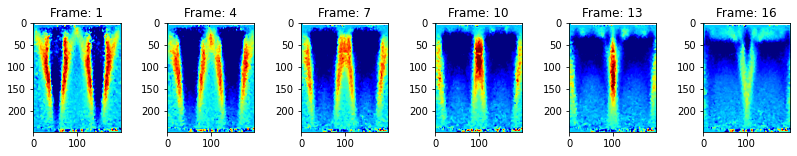

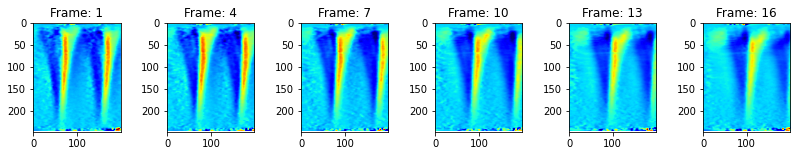

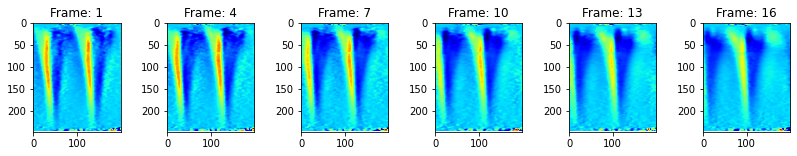

In [285]:
## Visualize results
# Filter masks
#DirFilter.plotFilterMasks()
# Filtered motion data frames
DrawShearWaveFrames(data=ddata_cpu,  Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])
DrawShearWaveFrames(data=ddata_f[0], Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])
DrawShearWaveFrames(data=ddata_f[1], Vrange=[-2e-3, 4e-3], frames=[1, 4, 7, 10, 13, 16])
# Plot some profiles
#%matplotlib widget
#fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#ax.plot(np.squeeze(ddata_LR[200, 350-15, :]))
#ax.plot(np.squeeze(ddata_LR[200, 350+15, :]))

## Local shear wave speed estimation

In [286]:
dim = ddata_f.shape
print(dim)
SWS_Estimator = SWS_Estimation(x_range=swse_x_range, z_clip = swse_z_clip, frames_range = swse_frames,
                               d=swse_d, fri = pwi_fri, interp_factor=swse_interp_factor, interp_order=swse_interp_order, 
                                px_pitch=px_size*1e-3, sws_range=swse_SWV_range)
SWS_Estimator.prepare(input_shape = ddata_f.shape)


(2, 249, 200, 120)


In [287]:
# SWS Estimation (benchmark)
n = 5
start = time.time()
for i in range(n):
    SWV = SWS_Estimator.process(data=ddata_f)
end = time.time()
print(f"Average time: {1000*(end-start)/n} [ms]")

Average time: 8170.2807903289795 [ms]


Text(0.5, 1.0, 'r_RL')

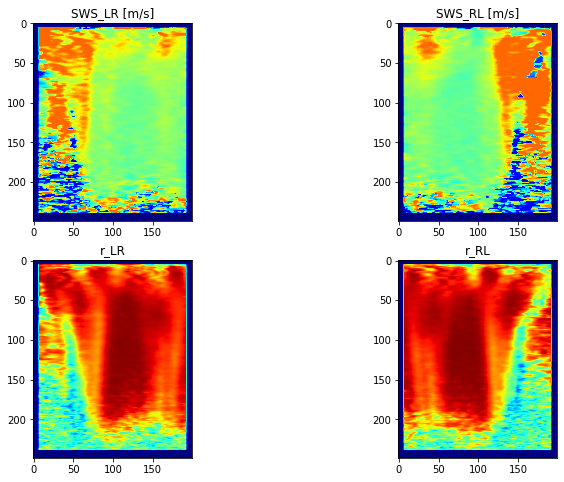

In [288]:
#Visualize the results
SWV_cpu = SWV
SWS_cpu = np.squeeze(SWV_cpu[0, ...])
SWS_r_cpu = np.squeeze(SWV_cpu[1, ...])
print()
norm_sws = plt.Normalize(0, 5, True)
norm_r   = plt.Normalize(0, 1, True)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs[0,0].imshow(np.squeeze(SWS_cpu[0,:,:]), cmap='jet', norm=norm_sws)
axs[0,0].set_title('SWS_LR [m/s]')

axs[1,0].imshow(np.squeeze(SWS_r_cpu[0,:,:]), cmap='jet', norm=norm_r)
axs[1,0].set_title('r_LR')

axs[0,1].imshow(np.squeeze(SWS_cpu[1,:,:]), cmap='jet', norm=norm_sws)
axs[0,1].set_title('SWS_RL [m/s]')

axs[1,1].imshow(np.squeeze(SWS_r_cpu[1,:,:]), cmap='jet', norm=norm_r)
axs[1,1].set_title('r_RL')


# Post-processing

## Image compounding

In [289]:
SWS_Compounder = SWS_Compounding()
SWS_Compounder.prepare()

In [290]:
# SWS Compounding (benchmark)
n = 100
start = time.time()
for i in range(n):
    SWSc = SWS_Compounder.process(SWV)
end = time.time()
print(f"Average time: {1000*(end-start)/n} [ms]")

Average time: 0.2937746047973633 [ms]


Text(0.5, 1.0, 'r_LR')

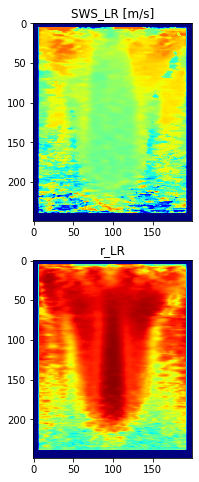

In [291]:
# Visualize results
SWSc_cpu  = SWSc
SWS_cpu = np.squeeze(SWSc_cpu[0, ...])
SWS_r_cpu = np.squeeze(SWSc_cpu[1, ...])
sws_range = [0.5, 4.0]
norm_sws = plt.Normalize(0, 5.0, True)
norm_r   = plt.Normalize(0, 2, True)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
axs[0].imshow(np.squeeze(SWS_cpu), cmap='jet', norm=norm_sws)
axs[0].set_title('SWS_LR [m/s]')

axs[1].imshow(np.squeeze(SWS_r_cpu), cmap='jet', norm=norm_r)
axs[1].set_title('r_LR')

## Image filtering

In [292]:
MedianFilter = MedianFiltering(kernel_size=5)
MedianFilter.prepare()

In [294]:
# Median filtering (benchmark)
n = 100
start = time.time()
for i in range(n):
    SWS_filtered = MedianFilter.process(SWSc)
end = time.time()
print(f"Average time: {1000*(end-start)/n} [ms]")

Average time: 9.438788890838623 [ms]
